# Homework 3

In this assignment you will work with a sub-section of the ethanol IR dataset which is loaded and visualized below:

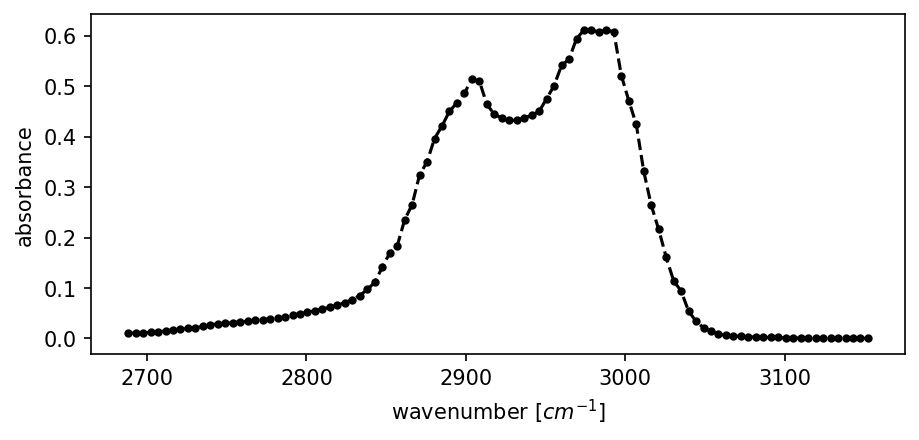

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1, 1)
y_peak = df['absorbance'].values[475:575]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Interpolation

Select every third datapoint from `x_peak` and `y_peak`. Save them to `x_third` and `y_third`, respectively.

In [2]:
x_third = x_peak[::3]
y_third = y_peak[::3]

Using these datapoints, train a `LinearRegression` model to predict the spectrum for all points in `x_peak`. Use piecewise linear functions for feature transformation, so that the result is a linear interpolation. Plot the prediction along with the original `y_peak`.

In [3]:
from sklearn.linear_model import LinearRegression

def piecewise_linear(x_train, x_test = None):
    if x_test is None:
        x_test = x_train
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = max(0, x_test[i] - x_train[j])
    return X

In [4]:
lr = LinearRegression()

X_train = piecewise_linear(x_third)
X_test = piecewise_linear(x_third, x_peak)

lr.fit(X_train, y_third)
y_hat = lr.predict(X_test)

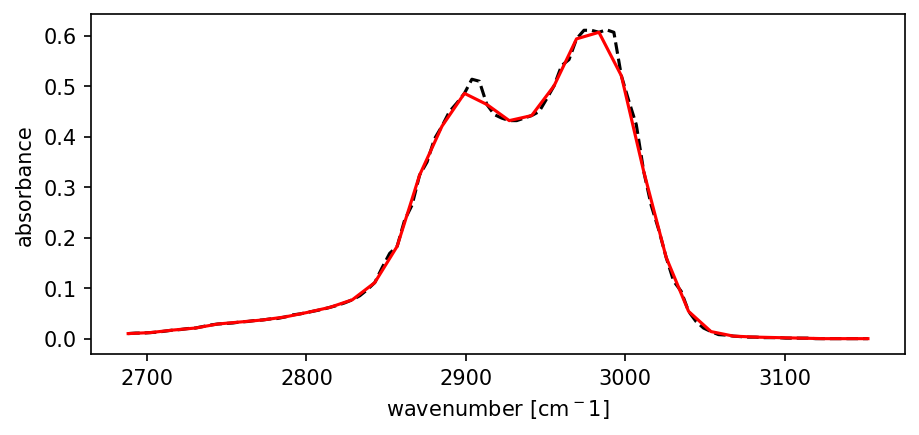

In [5]:
fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)

ax.plot(x_peak, y_peak, '--k', label = 'original peak')
ax.plot(x_peak, y_hat, '-r', label = 'interpolation')
ax.set_xlabel('wavenumber [$\mathrm{cm^-1}$]')
ax.set_ylabel('absorbance');

Next, you will do the same interpolation with the radial basis functions and evaluate the performance of RBF kernels as a function of kernel width $\sigma$, where $\gamma = \frac{1}{2\sigma^2}$. The width of the RBF will vary as $\sigma=$ [1, 10, 50, 100, 150, 500]. Plot the prediction results along with the original `y_peak`. 

You should create a single plot for each $\sigma$, which means a total 6 of plots should be present. If you are interested in making compact and neat mutiple plots, the [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function provides a very useful features.

In [6]:
def rbf(x_train, x_test = None, gamma = 0.001):
    if x_test is None:
        x_test = x_train

    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-gamma*(x_test[i] - x_train[j])**2)
    return X

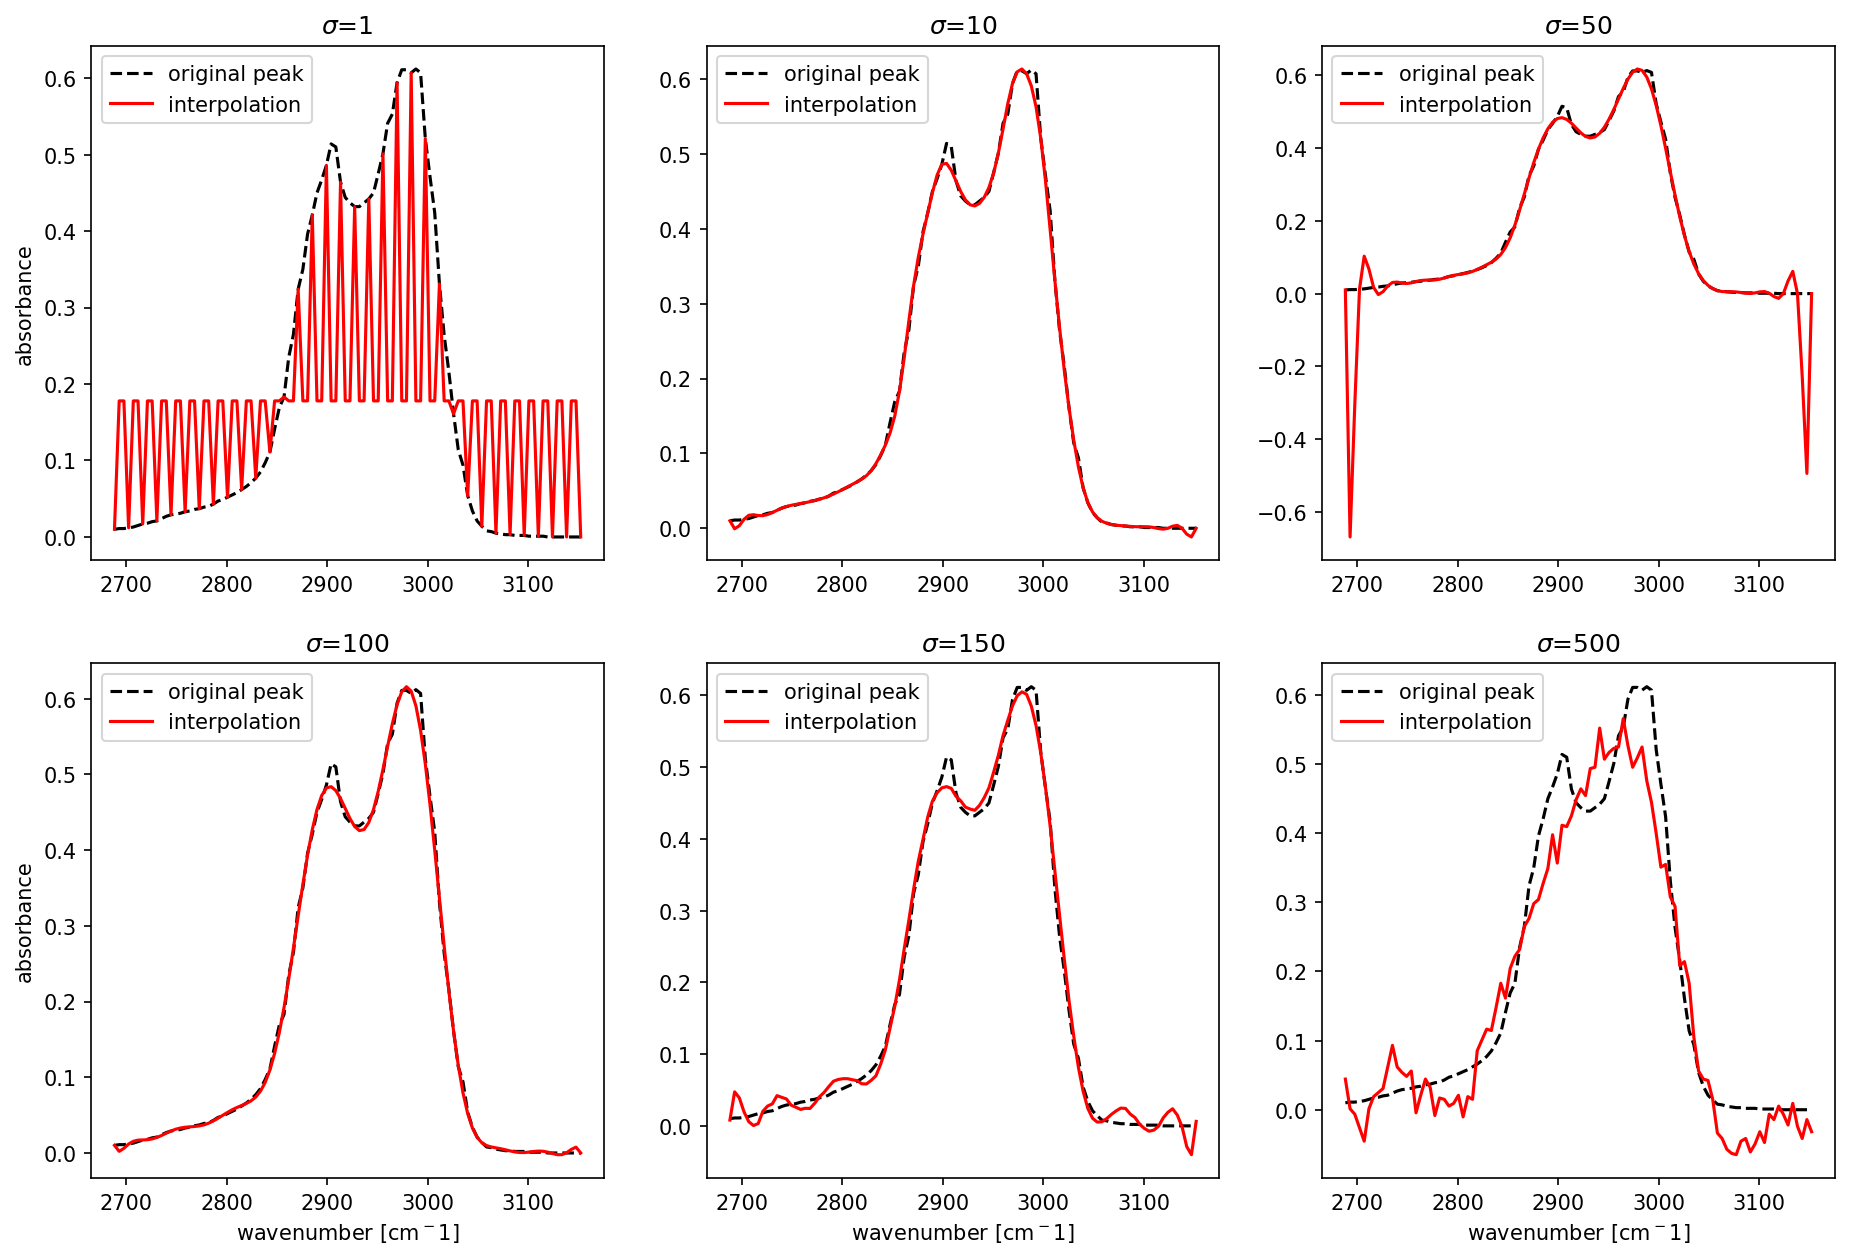

In [7]:
sigma = np.array([1, 10, 50, 100, 150, 500])
gamma = 1 / 2 / sigma**2

fig, axes = plt.subplots(2, 3, figsize = (15, 10), dpi = 150)
axes = axes.ravel()

for i, g in enumerate(gamma):
    lr = LinearRegression()
    
    X_train = rbf(x_third, x_third, g)
    lr.fit(X_train, y_third)
    
    X_test = rbf(x_third, x_peak, g)
    y_hat = lr.predict(X_test)
    
    axes[i].plot(x_peak, y_peak, '--k', label = 'original peak')
    axes[i].plot(x_peak, y_hat, '-r', label = 'interpolation')
    axes[i].set_title('$\sigma$={}'.format(sigma[i]))
    if i//3 == 1:
        axes[i].set_xlabel('wavenumber [$\mathrm{cm^-1}$]')
    if i%3 == 0:
        axes[i].set_ylabel('absorbance')
    axes[i].legend()

Finally, create a model that is trained on `x_third` and `y_third` where $r^2 < 0$ for predictions on `y_peak`. You can use any model from the lectures or make one up. Note that you don't have to optimize the hyperparameters model. Plot the prediction along with `y_peak` and provide the resulting $r^2$.

r2 = -0.17554988451492903


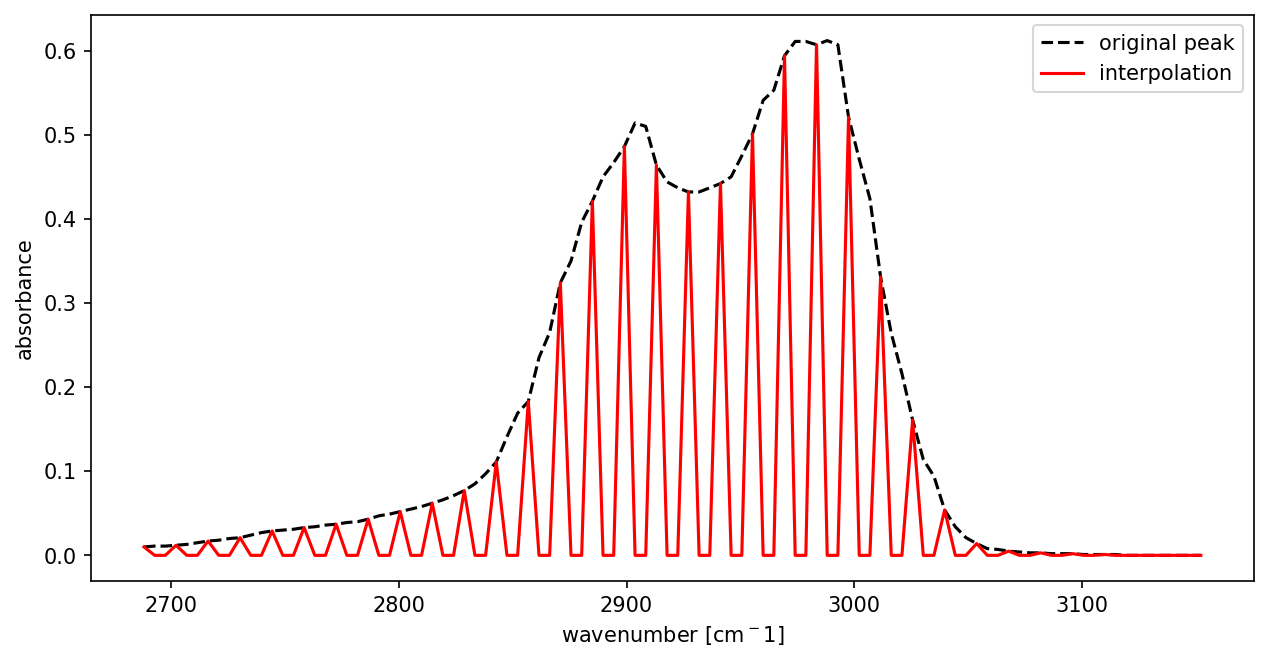

In [8]:
from sklearn.metrics import r2_score

lr = LinearRegression(fit_intercept = False)

X_train = rbf(x_third, x_third, gamma = 1e5)
lr.fit(X_train, y_third)

X_test = rbf(x_third, x_peak, gamma = 1e5)
y_hat = lr.predict(X_test)

print('r2 = {}'.format(r2_score(y_peak, y_hat)))

fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
ax.plot(x_peak, y_peak, '--k', label = 'original peak')
ax.plot(x_peak, y_hat, '-r', label = 'interpolation')

ax.set_xlabel('wavenumber [$\mathrm{cm^-1}$]')
ax.set_ylabel('absorbance')

ax.legend();

## 2. Cauchy Kernel Matrix

Consider the Cauchy Kernel Matrix defined by

$C\left(x, x_0, \gamma \right)=\frac{1}{\pi\gamma}\frac{\gamma^2}{\left(x-x_0\right)^2+\gamma^2}$

where $x_0$ is the center of the distribution, which is comparable to the mean ($\mu$) of a Gaussian distribution. $\gamma$ is a scale factor that is comparable to the standard deviation ($\sigma$) of a Gaussian distribution.

Write a function that computes the Cauchy kernel between any two vectors $x_i$ and $x_j$.

In [9]:
def cauchy_kernel(x_i, x_j, gamma):
    N = len(x_j)
    M = len(x_i)
    
    X = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            X[i, j] = gamma**2 / np.pi / gamma / ((x_i[j] - x_j[i])**2 + gamma**2)
    return X

Visualize kernel matrices between `x_peak` and `x_peak` itself. Vary the $\gamma$ with [1, 10, 100]. You may want to use the [`plt.imshow`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html) function to visualize the matrices. Here is an example of using `plt.imshow`.

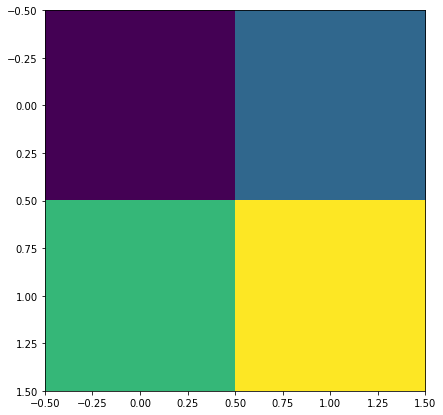

In [10]:
fig, ax = plt.subplots(figsize = (7, 7))

array = [[0, 1], [2, 3]]
ax.imshow(array, cmap = 'viridis');

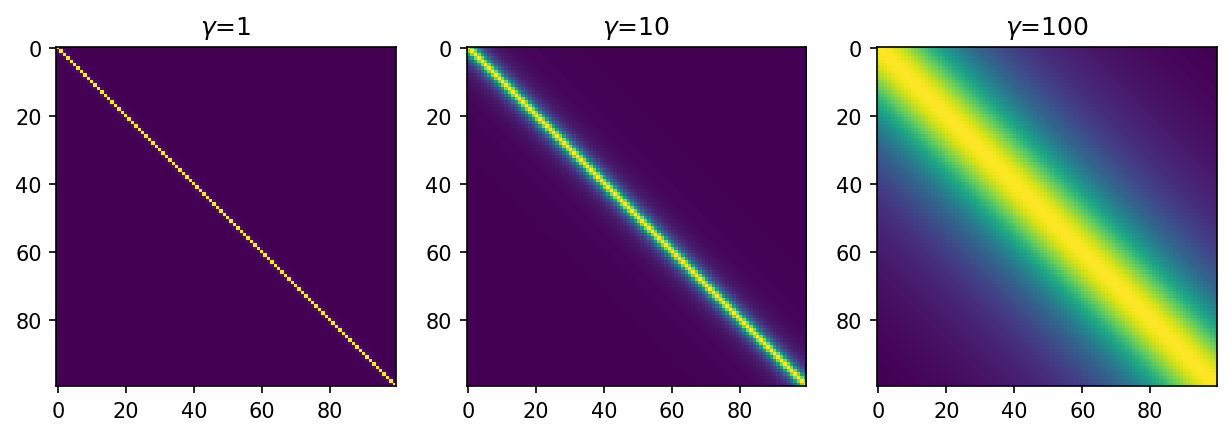

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3), dpi = 150)

gammas = [1, 10, 100]
for i in range(3):
    X = cauchy_kernel(x_peak, x_peak, gammas[i])
    axes[i].imshow(X, cmap = 'viridis')
    axes[i].set_title('$\gamma$={}'.format(gammas[i]))

Briefly discuss the structure of these matrices. You should address at least two of the following questions:

* What is the meaning of a row in this matrix? What is the meaning of a column?
* How does the value of an entry change as a function of distance between the points?
* What happens as $\gamma$ gets very large or very small?
* How is the matrix different from or similar to a radial basis function kernel matrix?

1. Each row means a test set data point, whereas each column means a training set data point.
2. As the distance between the points gets longer, the value will decrease.
3. If $\gamma$ gets very small, the resulting Cauchy kernel matrix becomes an identity matrix where only diagonal elements are 1. This will make a ML model hard to distinguish between different data points. This can be mitigated by increasing the value of $\gamma$, in which case the matrix tells the difference between very close data points and very far points, as you can see the plot above.
4. In general, RBF matrices look very similar to Cauchy kernel matrices, while $\gamma$ affects the distribution in an opposite way. With the Cauchy kernel, the bright region near the diagonal line gets wider as $\gamma$ increases. However, the same effect occurs when $\gamma$ decreases in case of the RBF kernel. See the plot below.

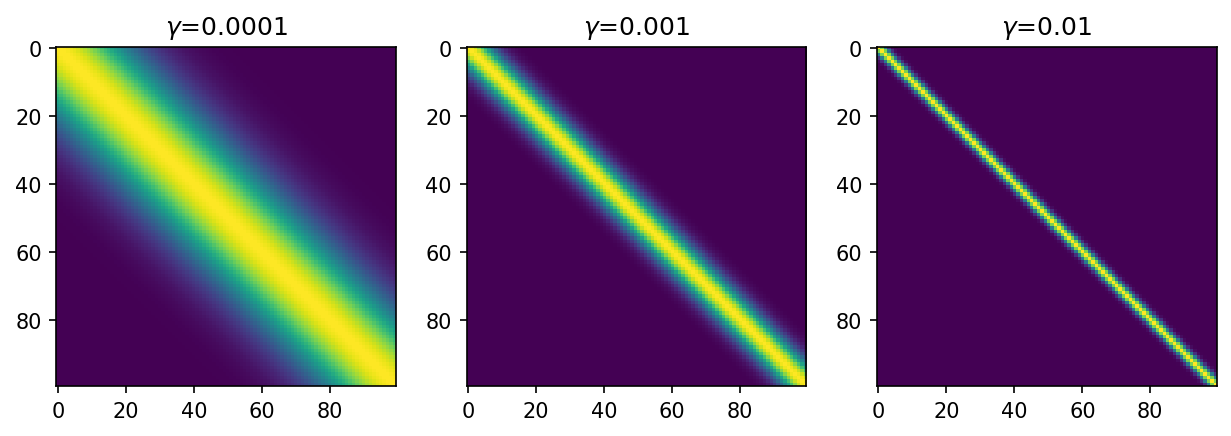

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3), dpi = 150)

gammas = [1e-4, 1e-3, 1e-2]
for i in range(3):
    X = rbf(x_peak, x_peak, gammas[i])
    axes[i].imshow(X, cmap = 'viridis')
    axes[i].set_title('$\gamma$={}'.format(gammas[i]))

## 3. Assumptions for Linear Regression

List the assumptions that must be valid for linear regression (and the corresponding uncertainty estimation based on standard deviation of the residuals) to be statistically rigorous.

**See the Module 2 Topic 2 Lesson 3 Slide 4.**